In [1]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plots
import seaborn as sns  # Data visualization
import statsmodels.regression.linear_model as sm  # Linear regression models
from statsmodels.tsa.stattools import adfuller, acovf  # Functions for stationarity tests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation graphs
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for fitting residuals
from IPython.display import display  # Function to display images in the notebook
from sklearn.metrics import mean_squared_error  # Function to calculate mean squared error


# **Short-term Predictions for Housing Price Analysis**

In this project we will calibrate a short-term prediction model and evaluate its performance by mean-squared errors. The data used for this analysis is from Zillow Group, and we will focus on the Boston housing market.

We assume an additive form of prediction model:

$$
\hat{X}_t = \hat{y}_t + AR_t, \quad \forall t
$$

where: $$ \hat{X}_t $$ is the estimated housing prices of Boston, $$ \hat{y}_t $$ is the non-stationary component captured by a Hankel-based unstructured model, and \( AR_t \) is the stationary component captured by an autoregressive model.

We calibrate this model in two steps:
1. Fit the Hankel-based unstructured model.
2. Calculate the residual series and fit the autoregressive model to match the residuals.


## **Data Processing**

The data comes from Zillow Group, contains a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type.

In [2]:
# Importing the data:
zillow_df = pd.read_csv("./data_zillow_house_prices.csv")
zillow_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,127881.0,128227.0,128591.0,129332.0,130079.0,...,318303.0,322658.0,327381.0,332588.0,337848.0,343392.0,348415.0,352585.0,354986.0,356026.0
1,394913,1,"New York, NY",msa,NY,224676.0,226018.0,227226.0,229604.0,231817.0,...,573600.0,576842.0,580804.0,585445.0,591876.0,599008.0,606525.0,612535.0,616856.0,619142.0
2,753899,2,"Los Angeles, CA",msa,CA,227786.0,228579.0,229794.0,232104.0,234580.0,...,845860.0,855023.0,865646.0,877802.0,895038.0,914016.0,930381.0,931707.0,928599.0,914636.0
3,394463,3,"Chicago, IL",msa,IL,170004.0,170405.0,170924.0,171963.0,173064.0,...,288807.0,291527.0,294162.0,296729.0,300023.0,303490.0,307454.0,310438.0,312286.0,312609.0
4,394514,4,"Dallas, TX",msa,TX,129921.0,130025.0,130112.0,130323.0,130544.0,...,337274.0,343129.0,350514.0,358982.0,367040.0,376487.0,385149.0,392668.0,394861.0,393920.0


In [3]:
# Filtering data for Boston:
boston_df = zillow_df[zillow_df['RegionName'] == 'Boston, MA']  

In [4]:
# Transpose the dataframe to have dates as the index:
boston_prices = boston_df.iloc[:, 5:].transpose()
# Rename the column for easier access
boston_prices.columns = ['Prices']

boston_prices

,Prices
2000-01-31,231718.0
2000-02-29,233010.0
2000-03-31,234265.0
2000-04-30,236467.0
2000-05-31,238657.0
...,...
2022-04-30,643355.0
2022-05-31,651279.0
2022-06-30,656882.0
2022-07-31,658173.0


In [5]:
# Filtering data for train and test period:
boston_train = boston_prices['2010-01-31':'2017-12-31']
boston_test = boston_prices['2018-01-01':'2019-12-31']

## **1. Hankel-based Unstructured Model**

### **ACF / PACF:**

Here we calculate and visualize the autocovariance values of the training data.

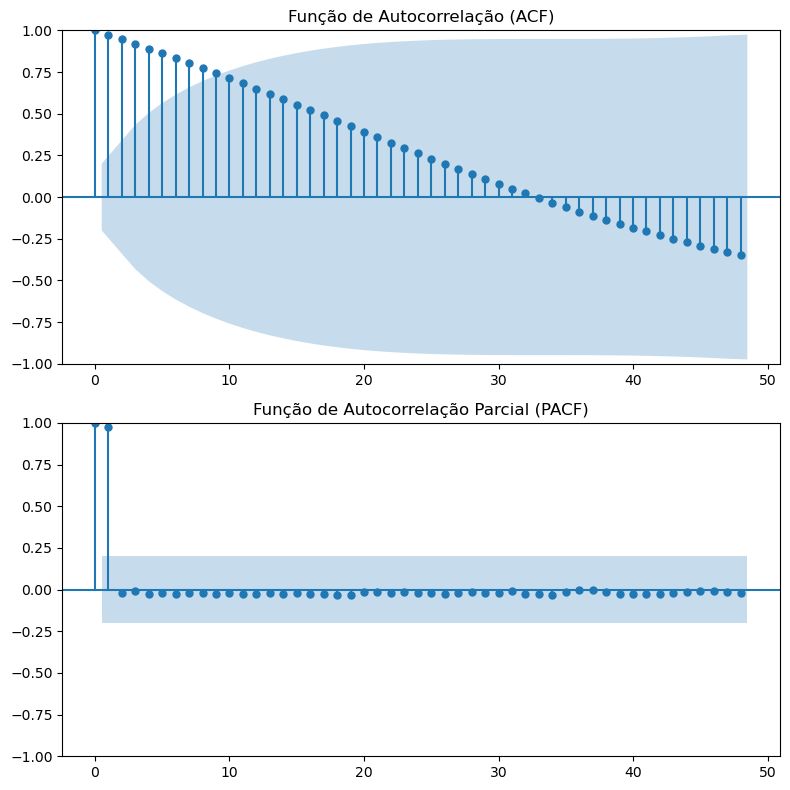

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot ACF
plot_acf(boston_train, ax=ax1, lags=48)
ax1.set_title('Função de Autocorrelação (ACF)')

# Plot PACF 
plot_pacf(boston_train, ax=ax2, lags=48)
ax2.set_title('Função de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

### **Hankel Matrix:**

A Hankel matrix can be formulated from the time series data.


$$
\Large H = \begin{bmatrix}
X_1 & X_2 & X_3 & \dots & X_{L-m+1} \\
X_2 & X_3 & X_4 & \dots & X_{L-m+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
X_m & X_{m+1} & X_{m+2} & \dots & X_L
\end{bmatrix}
$$

Note that we use the original training data to construct this Hankel matrix.

We'll use this Hankel Matrix to construct a denoised version of it.

In [7]:
# Parameters
m = 10
L = 50
last_L_values = boston_train.iloc[-L:]

# Construct the Hankel matrix
hankel = np.zeros((m, L - m + 1))

for i in range(m):
    # Extract the values and convert to 1D array
    values = last_L_values.iloc[i : i + (L - m + 1)].values.flatten()
    hankel[i] = values

hankel.shape


(10, 41)

### **SVD:**

Here, we perform singular-value thresholding on the Hankel matrix.

In [8]:
# Calculating the SVD:
U , s , Vh = np.linalg.svd(hankel, full_matrices=False)

In [9]:
# Checking dimensions:
print(U.shape, s.shape, Vh.shape)

# Displaying matrices:
print('U =\n',U,'\n')
print('V_trans =\n',Vh,'\n')
print('s =\n',s,'\n')

(10, 10) (10,) (10, 41)
U =
 [[-0.31017914 -0.37778628  0.37055541  0.4582331  -0.46551432  0.33385381
   0.15032124  0.21637647 -0.0832846  -0.09624978]
 [-0.31147831 -0.39700893  0.29545853  0.09869751  0.16351226 -0.39713704
  -0.23040391 -0.50229565  0.32327444  0.23233789]
 [-0.31279689 -0.3605692   0.06128185 -0.26740719  0.41696121 -0.19419561
  -0.09368327  0.36867705 -0.56916549 -0.12910704]
 [-0.31413257 -0.25748294 -0.23924047 -0.39545791  0.14426378  0.26648637
   0.40594375  0.05248838  0.53858301 -0.26824664]
 [-0.3154964  -0.09744683 -0.45575781 -0.20161601 -0.25808029  0.32015891
  -0.25261527 -0.08041249 -0.16700339  0.61263693]
 [-0.31685701  0.07958639 -0.46544107  0.16708825 -0.28453616 -0.28424987
   0.01437992 -0.38526867 -0.24905379 -0.52563146]
 [-0.31821808  0.23833917 -0.26386943  0.399075    0.1099307  -0.27417187
  -0.23830694  0.56938584  0.37270775  0.0767287 ]
 [-0.31957101  0.34446443  0.04141496  0.30397071  0.4089135   0.10390904
   0.57851048 -0.20471

In [10]:
# Creating a diagonal matrix with the singular values:
s_mat = np.diag(s)

#Estimate rank of Page matrix
r=0;
for i in range(L):
 if (sum(np.square(s[:i]))/sum(np.square(s)))>=0.99:
    r=i;
    break;
print('\n The 90% singular value is concentrated in the first r dimensions, r=',r)

# Constructing the truncated singular matrix:
strunmat = np.zeros((int(m), int(m)))
strunmat[:r, :r] = np.diag(s[0:r])
print('Truncated S matrix:\n', strunmat, '\n')



 The 90% singular value is concentrated in the first r dimensions, r= 1
Truncated S matrix:
 [[8364075.45019703       0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.            

In [11]:
# Cronstructing denoised matrix:
hankel_hat = U @ strunmat @ Vh

hankel_hat

array([[373859.9650905 , 375253.2616231 , 376455.34466908,
        377514.86047444, 378607.41463261, 379842.74690909,
        381191.79248915, 382555.59186239, 383804.91174769,
        385045.90688291, 386321.00606493, 387790.45661877,
        389437.74190963, 391193.7493244 , 392948.16916173,
        394560.97325478, 395985.75413881, 397408.96871866,
        398982.55042167, 400712.57361036, 402573.638375  ,
        404514.9379054 , 406533.9417091 , 408495.26698632,
        410332.95536178, 412187.38759558, 414098.70825237,
        416087.50107154, 418048.32678164, 419946.84302866,
        421742.73850682, 423458.49696304, 425216.24476874,
        427138.27068895, 429269.95319507, 431508.56076685,
        433720.8402648 , 435847.84690237, 437945.0938272 ,
        440165.88036355, 442465.63011373],
       [375425.8600603 , 376824.99235024, 378032.1102648 ,
        379096.06380253, 380193.19407268, 381433.70048059,
        382788.39647493, 384157.90805803, 385412.46066122,
        38665

### **OLS Regression:**

Now we conduct an ordinary least squares (OLS) approach to fit a regression model. The OLS regression will derive a parametric model to capture the non-stationary trend, and note that we don't consider constant terms. 

We then use this model to generate the predictions for some training and test months, and these estimations could guide us to the residual series and the non-stationary component for predictions on test months.

In [12]:
# Extracting last row of hankel:
y = hankel[-1,:].reshape(-1, 1)

# Extracting all rows except the last one:
x = hankel_hat[:-1,:]

# Checking dimensions:
x.shape, y.shape

((9, 41), (41, 1))

In [13]:
# Fitting OLS model without a constant term:
model = sm.OLS(y, x.T)

# Fitting the model:
results = model.fit()

# Extracting coefficients:
betas = results.params.reshape(-1,1)

# Displaying model summary:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.897e+06
Date:                Thu, 05 Dec 2024   Prob (F-statistic):                    7.95e-99
Time:                        21:47:25   Log-Likelihood:                         -359.75
No. Observations:                  41   AIC:                                      721.5
Df Residuals:                      40   BIC:                                      723.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1116   6.56e-05   1702.059      0.000       0.111       0.112
x2             0.1121   6.58e-05   1702.059      0.000       0.112       0.112
x3             0.1125   6.61e-05   1702.059      0.000       0.112       0.113
x4             0.1130   6.64e-05   1702.059      0.000       0.113       0.113
x5             0.1135   6.67e-05   1702.059      0.000       0.113       0.114
x6             0.1140    6.7e-05   1702.059      0.000       0.114       0.114
x7             0.1145   6.73e-05   1702.059      0.000       0.114       0.115
x8             0.1150   6.75e-05   1702.059      0.000       0.115       0.115
x9             0.1155   6.78e-05   1702.059      0.000       0.115       0.116
==============================================================================
Omnibus:                        6.513   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.190
Skew:                          -0.787   Prob(JB):                       0.0746
Kurtosis:                       3.750   Cond. No.                     1.46e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.94e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
# Extracting the last 9 values:
x_est = boston_train.tail(9)

# Reshape to have a column matrix:
x_est = x_est.values.reshape(-1,1)

x_est, betas


(array([[442791.],
        [445409.],
        [448045.],
        [450885.],
        [452393.],
        [454372.],
        [455955.],
        [459183.],
        [461409.]]),
 array([[0.11158297],
        [0.11205033],
        [0.11252467],
        [0.11300517],
        [0.11349578],
        [0.11398525],
        [0.11447487],
        [0.11496157],
        [0.11545886]]))

In [15]:
# Calculating the prediction:
nonstat_predict = betas.T @ x_est.reshape(-1,1)

nonstat_predict/1000



array([[462.07855839]])

## **2. Autoregressive Model**

### **Short-term Forecast:**


<img src="./images/svd_4.png" alt="Descrição da Imagem" width="700"/>

#### **Plotting Residuals and checking Stationarity:**

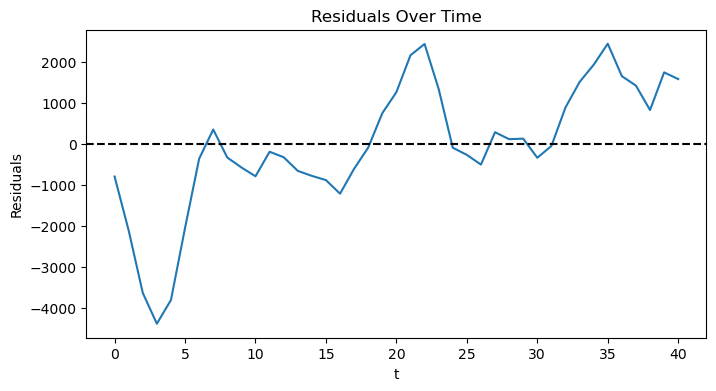

In [16]:
residuals = results.resid

plt.figure(figsize=(8,4))
sns.lineplot(data=residuals)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Residuals Over Time')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.show()



In [17]:
# Here we check stationarity running the Adfuller Test
adf_test = adfuller(residuals, regression='n')

adf_test[1] # p_value


0.019854898742282714

As we found a p-value of approximately 2%, we can proceed to fit an AR model to the residuals.

### **Fitting AR to the residuals:**

In this step, we will develop an autoregressive (AR) model to capture the residual series. We'll stick to an AR(3) model, but feel free to experiment with different orders.

In [18]:
model = ARIMA(residuals, order=(3,0,0))

results = model.fit()

results.summary()   


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -320.601
Date:                Thu, 05 Dec 2024   AIC                            651.202
Time:                        21:47:26   BIC                            659.770
Sample:                             0   HQIC                           654.322
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.2640    515.990     -0.107      0.915   -1066.585     956.057
ar.L1          1.4325      0.198      7.218      0.000       1.044       1.821
ar.L2         -0.6648      0.338     -1.969      0.049      -1.326      -0.003
ar.L3          0.0397      0.205      0.193      0.847      -0.363       0.442
sigma2      3.423e+05   9.97e+04      3.434      0.001    1.47e+05    5.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.97   Prob(JB):                         0.80
Heteroskedasticity (H):               1.11   Skew:                             0.06
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The prediction for one typical month is the addition of the results from the Hankel-based regression model and the above AR(3) model. 

The final prediction for the test period is concatenation of all these monthly estimates.

In [19]:
# Making the point forecast for the next period
stat_predict = results.predict(start=len(residuals), end=len(residuals))

# Calculating the forecast for the next period:
total_predict = nonstat_predict + stat_predict[0]
print(f"Non-stationary component forecast: {nonstat_predict[0][0]:.2f}")
print(f"Stationary component forecast: {stat_predict[0]:.2f}")
print(f"Total forecast for the next period: {total_predict[0][0]:.2f}")



Non-stationary component forecast: 462078.56
Stationary component forecast: 1120.85
Total forecast for the next period: 463199.40


### **Rolling Predictions:**

<img src="./images/svd_5.png" alt="Descrição da Imagem" width="700"/>

In [20]:
# Function for one-month ahead prediction:
def make_single_prediction(train_data, L, m, r=2):
    # Get the last L values:
    last_L_values = train_data.iloc[-L:]
    
    # Construct Hankel matrix:
    hankel = np.zeros((m, L - m + 1))
    for i in range(m):
        values = last_L_values.iloc[i : i + (L - m + 1)].values.flatten()
        hankel[i] = values
    
    # SVD:
    U, s, Vh = np.linalg.svd(hankel, full_matrices=False)
    
    # Truncated singular matrix:
    strunmat = np.zeros((int(m), int(m)))
    strunmat[:r,:r] = np.diag(s[0:r])
    
    # Reconstruct Hankel matrix:
    hankel_hat = U @ strunmat @ Vh
    
    # OLS Regression:
    y = hankel[-1,:].reshape(-1, 1)
    x = hankel_hat[:-1,:]
    
    # Fit OLS model:
    model = sm.OLS(y, x.T)
    results = model.fit()
    betas = results.params.reshape(-1,1)
    
    # Non-stationary component prediction (Hankel>SVD>Reconstruct>OLS):
    x_previous = train_data.tail(m-1).values.reshape(-1,1)  # Last m-1 values
    nonstat_predict = betas.T @ x_previous.reshape(-1,1) # Dot product
    
    # Stationary component prediction (AR(3) on residuals):
    residuals = results.resid
    arima_model = ARIMA(residuals, order=(3,0,0), trend='n')
    arima_results = arima_model.fit()
    stat_predict = arima_results.predict(start=len(residuals), end=len(residuals))
    
    # Total prediction:
    total_predict = nonstat_predict + stat_predict[0]
    
    return total_predict[0][0]

# Perform rolling predictions:
def make_rolling_predictions(train_data, test_data, n_steps, L, m):
    predictions = []
    current_train = train_data.copy()
    
    for _ in range(n_steps):
        # Make prediction:
        pred = make_single_prediction(current_train, L, m)
        predictions.append(pred)
        
        # Add prediction to training set:
        new_index = pd.date_range(start=current_train.index[-1], periods=2, freq='M')[1]
        current_train.loc[new_index] = test_data.iloc[_]['Prices']
    
    #print(current_train.tail(30))  ### uncomment to check updates

    return predictions


In [21]:
# Generating rolling predictions:
n_predictions = len(boston_test)
rolling_forecast = make_rolling_predictions(boston_train, boston_test, n_predictions, 50, 10)

# Create DataFrame with predictions:
forecast_dates = pd.date_range(start=boston_train.index[-1], periods=25, freq='M')[1:]
forecast_df = pd.DataFrame(rolling_forecast, index=forecast_dates, columns=['Prices'])

# MSE
mse = mean_squared_error(boston_test['Prices'], forecast_df['Prices'])
print(f'Mean Squared Error (MSE): {mse/1e3}')



Mean Squared Error (MSE): 1262.356475575789


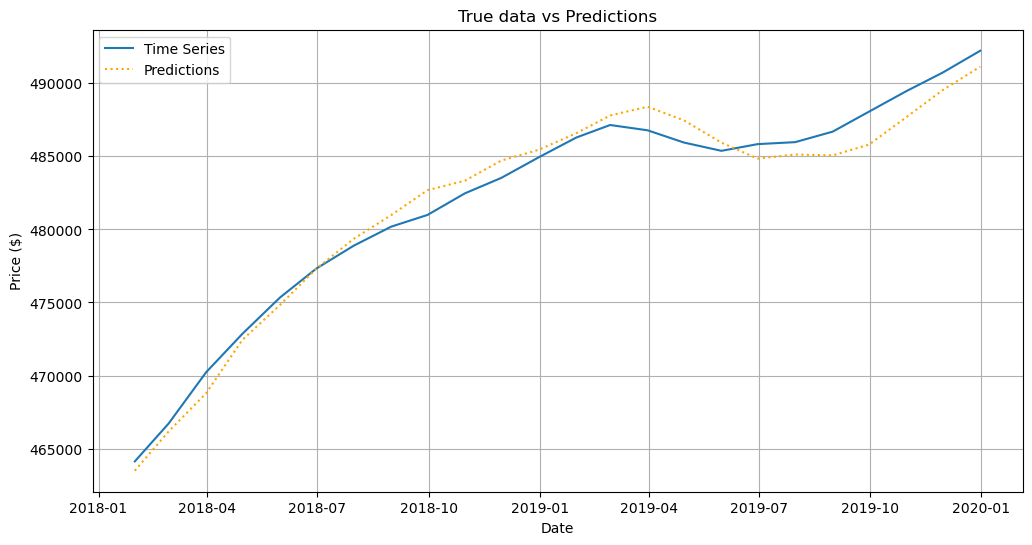

In [22]:
# Creating the plot
plt.figure(figsize=(12, 6))

# Converting indices to datetime with timezone
boston_test.index = pd.to_datetime(boston_test.index, utc=True)
forecast_df.index = pd.to_datetime(forecast_df.index, utc=True)

# Plotting the time series only for the test period
plt.plot(boston_test.index, boston_test['Prices'], 
         label='Time Series')

# Plotting the predictions only for the test period
plt.plot(forecast_df.index, forecast_df['Prices'], 
         label='Predictions',
         linestyle=':',
         color='orange')

# Customizing the plot
plt.title('True data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)


plt.show()


Upon analyzing the plot and our MSE, we observe a slight delay in the model's adaptation to changes in trend; however, it fits the data reasonably well overall.

